In [23]:
#############################
## Load necessary packages ##
#############################

import datetime
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import output_to_visuals
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 1: setup national COVID-19 SEIQRD

In [21]:
################################
## Define simulation settings ##
################################

# Number of simulations
N=20
# Number of neg. binomial draws/ simulation
K=100
# Number of age groups
age_stratification_size=10
# End of simulation
end_sim='2021-03-01'
# Confidence level used to visualise model fit
conf_int=0.05

In [17]:
##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# Deaths in hospitals
df_sciensano_mortality = sciensano.get_mortality_data()
deaths_hospital = df_sciensano_mortality.xs(key='all', level="age_class", drop_level=True)['hospital','cumsum']

In [18]:
##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size)

warmup = float(BASE_samples_dict['warmup'])
dispersion = float(BASE_samples_dict['dispersion'])
start_sim = BASE_samples_dict['start_calibration']

#######################
## Sampling function ##
#######################

from covid19model.models.utils import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fcn

In [22]:
#########################
## Perform simulations ##
#########################

print('\n1) Simulating COVID19_SEIQRD_hybrid_vacc '+str(N)+' times')

out = model.sim(end_sim,start_date=start_sim,warmup=warmup, N=N,draw_fcn=draw_fcn,samples=BASE_samples_dict)
df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'S', 'R', 'D'], alpha=dispersion, n_draws_per_sample=K, UL=1-conf_int*0.5, LL=conf_int*0.5)
simtime = out['time'].values


1) Simulating COVID19_SEIQRD_hybrid_vacc 20 times


2) Visualizing fit


NameError: name 'datetime' is not defined

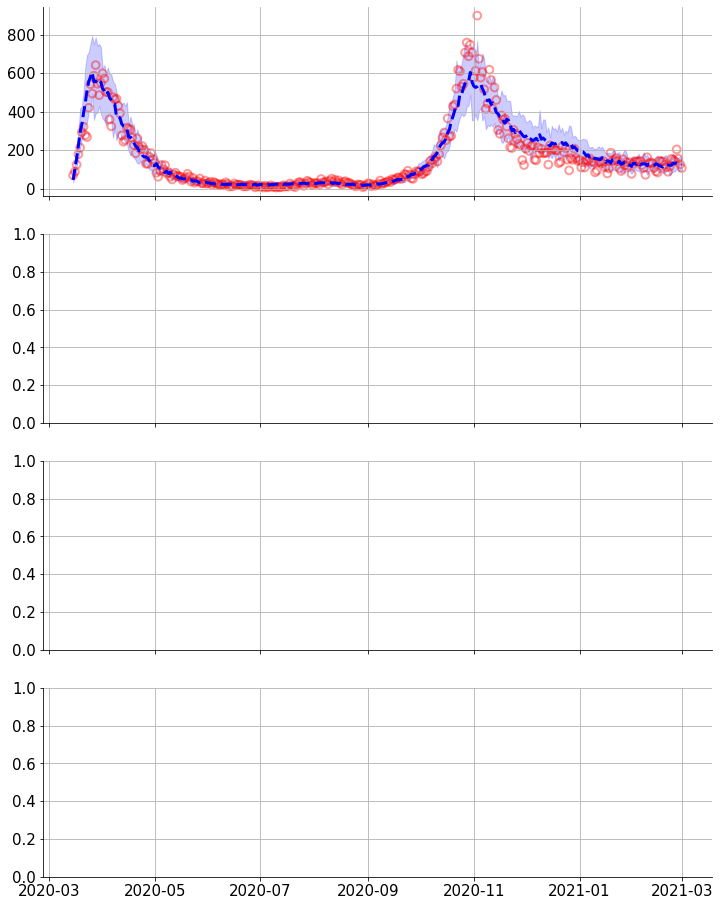

In [20]:
#######################
## Visualize results ##
#######################

print('2) Visualizing fit')

# Plot hospitalizations
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1,figsize=(12,16),sharex=True)
ax1.plot(df_2plot['H_in','mean'],'--', color='blue')
ax1.fill_between(simtime, df_2plot['H_in','lower'], df_2plot['H_in','upper'],alpha=0.20, color = 'blue')
ax1.scatter(df_hosp[start_sim:end_sim].index,df_hosp['H_in'][start_sim:end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1.scatter(df_hosp[pd.to_datetime(end_sim)+datetime.timedelta(days=1):end_sim].index,df_hosp['H_in'][pd.to_datetime(end_sim)+datetime.timedelta(days=1):end_sim], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1 = _apply_tick_locator(ax1)
ax1.set_xlim(start_sim,end_sim)
ax1.set_ylabel('Daily hospitalizations (-)', fontsize=12)
ax1.get_yaxis().set_label_coords(-0.1,0.5)